# Cloud Detection using Clustering

### Importing the image

In [44]:
import math
import rasterio
import numpy as np
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt

image_file = "3DIMG_07NOV2019_0000_L1C_SGP.tif"
sat_data = rasterio.open(image_file)

### Calculating the dimensions of the image on earth in metres

In [45]:
width_in_projected_units = sat_data.bounds.right - sat_data.bounds.left
height_in_projected_units = sat_data.bounds.top - sat_data.bounds.bottom

print("Width: {}, Height: {}".format(width_in_projected_units, height_in_projected_units))

Width: 36.013661782652136, Height: 32.995757163994135


### Rows and Columns

In [46]:
print("Rows: {}, Columns: {}".format(sat_data.height, sat_data.width))

Rows: 984, Columns: 1074


### Converting the pixel co-ordinates to longitudes and latitudes

In [47]:
# Upper left pixel
row_min = 0
col_min = 0

# Lower right pixel.  Rows and columns are zero indexing.
row_max = sat_data.height - 1
col_max = sat_data.width - 1

# Transform coordinates with the dataset's affine transformation.
topleft = sat_data.transform * (row_min, col_min)
botright = sat_data.transform * (row_max, col_max)

print("Top left corner coordinates: {}".format(topleft))
print("Bottom right corner coordinates: {}".format(botright))

Top left corner coordinates: (62.9883746791066, 38.02897834557538)
Bottom right corner coordinates: (95.9505995695601, 2.0488488364638897)


### Bands

The image that we are inspecting is a multispectral image consisting of 1 band stored as a numpy array.

In [48]:
print(sat_data.count)

# sequence of band indexes
print(sat_data.indexes)

1
(1,)


## Visualising the Satellite Imagery

We will use matplotlib to visualise the image since it essentially consists of arrays.

In [49]:
# Load the 4 bands into 2d arrays - recall that we previously learned PlanetScope band order is BGRN.
b = sat_data.read(1)
print(b.shape)
flatten_b = b.flatten('F')

(984, 1074)


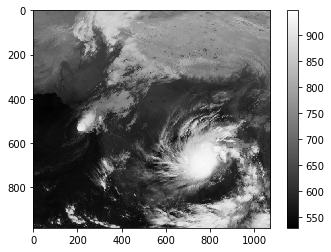

<Figure size 432x288 with 0 Axes>

In [50]:
# Displaying the blue band.

fig = plt.imshow(b)
plt.gray()
plt.colorbar()
plt.show()
plt.savefig('satellite.jpg')

## Feature Extraction

Feature vector of length 4 consists of mean, standard deviation, busyness and entropy.

In [51]:
def feature_mean(values):
    return np.nanmean(values)

def feature_std(values):
    return np.nanstd(values)

def feature_entropy(values):
    total = np.nansum(values)
    entropy = 0.0
    for x in values:
        u=x/total
        entropy+=(u*(1-u))
    return entropy

def feature_busyness(values):
    return (abs(values[0]-values[1])+abs(values[1]-values[2])+abs(values[2]-values[5])+abs(values[5]-values[8])+
    abs(values[8]-values[7])+abs(values[7]-values[6])+abs(values[6]-values[3])+abs(values[3]-values[0])+
    abs(values[1]-values[4])+abs(values[3]-values[4])+abs(values[5]-values[4])+abs(values[7]-values[4]))/12.0

In [52]:
mask = np.ones((3, 3))
mask[1, 1] = 0
mean_result = ndimage.generic_filter(b, feature_mean, footprint=mask, mode='constant', cval=np.NaN)
#print(mean_result)

In [53]:
std_result = ndimage.generic_filter(b, feature_std, footprint=mask, mode='constant', cval=np.NaN)
#print(std_result)

In [54]:
entropy_result = ndimage.generic_filter(b, feature_entropy, footprint=mask, mode='constant', cval=np.NaN)
#print(entropy_result)

In [55]:
#busyness_result = ndimage.generic_filter(b, feature_busyness, footprint=mask, mode='constant', cval=np.NaN)
#print(busyness_result)

In [56]:
mean_result = mean_result.flatten('F')
std_result = std_result.flatten('F')
entropy_result = entropy_result.flatten('F')
#busyness_result = busyness_result.flatten('F')

In [57]:
df = pd.DataFrame()
df['mean_result'] = mean_result
df['std_result'] = std_result
df['entropy_result'] = entropy_result
#df['busyness_result'] = busyness_result
df = df.fillna(0)

In [58]:
from sklearn.cluster import KMeans

In [59]:
k = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
k.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [60]:
k.cluster_centers_

array([[7.84584069e+02, 7.93684797e+00, 8.71799466e-01],
       [6.12464429e+02, 5.79863527e+00, 8.73067753e-01],
       [7.31021019e+02, 9.77793464e+00, 8.70604192e-01],
       [5.59087240e+02, 2.62758831e+00, 8.70713087e-01],
       [8.73927786e+02, 5.58403447e+00, 8.70825041e-01],
       [6.71986267e+02, 1.24356461e+01, 8.71337076e-01]])

In [61]:
k.labels_
print(len(k.labels_))

1056816


In [62]:
sample = k.labels_
sample = sample.astype(float)
print(np.unique(sample))
i=0
new_list=[]
while i<len(sample):
    new_list.append(list(sample[i:i+984]))
    i+=984
print(type(new_list))

[0. 1. 2. 3. 4. 5.]
<class 'list'>


In [63]:
print(len(new_list))
#print(new_list[:1])

1074


In [64]:
y=np.array([np.array(xi) for xi in new_list])

In [65]:
print(type(y))
print(y[:3])
y.shape

<class 'numpy.ndarray'>
[[2. 2. 2. ... 3. 3. 3.]
 [2. 2. 2. ... 3. 3. 3.]
 [2. 2. 2. ... 1. 1. 1.]]


(1074, 984)

1071


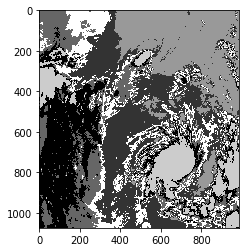

In [66]:
print(len(y[:-3]))
og=y
plt.imshow(y)
plt.show()

In [67]:
avg_dict={}
for val in np.unique(sample):
    val_index = list(np.where(sample==val))
    print(val_index)
    avg=0
    print(flatten_b[2])
    for i in val_index:
        avg+=flatten_b[i]
    print(len(val_index[0]))
    avg_dict[val] = np.sum(avg)/len(val_index[0])
print(avg_dict)

[array([  62804,   63787,   63788, ..., 1056813, 1056814, 1056815],
      dtype=int64)]
719.0
192192
[array([    341,     342,     343, ..., 1056725, 1056726, 1056727],
      dtype=int64)]
719.0
258528
[array([      0,       1,       2, ..., 1056748, 1056749, 1056750],
      dtype=int64)]
719.0
159280
[array([    380,     381,     382, ..., 1026036, 1052513, 1052514],
      dtype=int64)]
719.0
206748
[array([ 112153,  112154,  113137, ..., 1056801, 1056802, 1056803],
      dtype=int64)]
719.0
99979
[array([    112,     113,     114, ..., 1056745, 1056746, 1056747],
      dtype=int64)]
719.0
140089
{0.0: 785.2630702630703, 1.0: 611.8374179972769, 2.0: 731.2545956805625, 3.0: 558.7922688490336, 4.0: 874.7371347983077, 5.0: 671.672836553905}


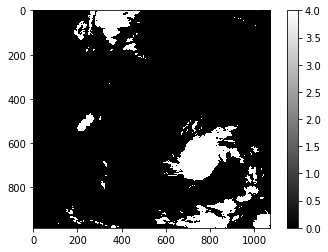

In [68]:
for i in range(0, len(new_list)):
    for j in range(0, len(new_list[i])):
        if new_list[i][j] != 4.0:
            new_list[i][j] = 0
y=np.array([np.array(xi) for xi in new_list])
y=np.rot90(y,3)
y=np.flip(y, 1)
#y=np.rot90(y)
#y=np.rot90(y)
plt.imshow(y)
plt.colorbar()
#plt.show()plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()

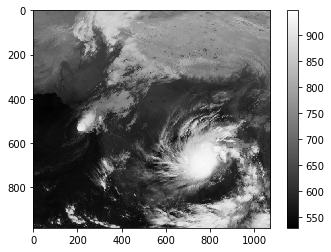

In [69]:
fig = plt.imshow(b)
plt.gray()
plt.colorbar()


In [70]:
from scipy import ndimage
image=y
edges = image - ndimage.morphology.binary_dilation(image) 
print(edges[:1])

[[0. 0. 0. ... 0. 0. 0.]]


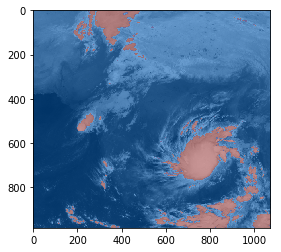

In [71]:
plt.imshow(b, cmap='gray')
plt.imshow(edges, cmap='jet', alpha=0.4)

In [72]:
def check(values):
    sumv=np.sum(values)
    if sumv == 0.0 or sumv == 32.0:
        return 0.0
    return 1.0

In [73]:
edge_result = ndimage.generic_filter(y, check, footprint=mask, mode='constant', cval=np.NaN)
print(edge_result)
#plt.imshow(b, cmap='gray')
#plt.savefig('output.png')

[[1. 1. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


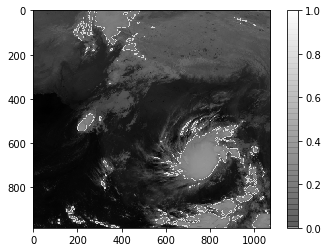

In [74]:
plt.imshow(b, cmap='gray')
plt.imshow(edge_result, cmap='gray', alpha=0.4)
plt.colorbar()

In [75]:
global cloud_pixel_list
cloud_pixel_list=[]
label_number = []
for row in range(0, 984):
    for col in range(0, 1074):
        if y[row][col] == 4.0:
            cloud_pixel_list.append([row, col])
            label_number.append(1)
print(cloud_pixel_list)

'''pending_list = cloud_pixel_list[0]
processed = {}
current = 2
while len(pending_list) > 0:
    center = pending_list.pop(0)
    label_number[cloud_pixel_list.index(center)] = current
        
    if [center[0]-1, center[1]-1] in cloud_pixel_list:
        label_number[cloud_pixel_list.index(center)] = current'''

[[0, 258], [0, 259], [0, 260], [0, 261], [0, 262], [0, 263], [0, 264], [0, 265], [0, 266], [0, 267], [0, 268], [0, 269], [0, 270], [0, 271], [0, 272], [0, 273], [0, 274], [0, 275], [0, 276], [0, 277], [0, 278], [0, 279], [0, 280], [0, 283], [0, 284], [0, 285], [0, 286], [0, 287], [0, 288], [0, 289], [0, 290], [0, 291], [0, 292], [0, 293], [0, 294], [0, 295], [0, 296], [0, 297], [0, 298], [0, 299], [0, 300], [0, 301], [0, 302], [0, 303], [0, 304], [0, 305], [0, 306], [0, 307], [0, 308], [0, 309], [0, 310], [0, 311], [0, 312], [0, 313], [0, 314], [0, 315], [0, 316], [0, 317], [0, 318], [0, 319], [0, 320], [0, 321], [0, 322], [0, 323], [0, 324], [0, 325], [0, 326], [0, 327], [0, 328], [0, 329], [0, 330], [0, 331], [0, 332], [0, 333], [0, 334], [0, 335], [0, 336], [0, 337], [0, 338], [0, 339], [0, 340], [0, 341], [0, 342], [0, 343], [0, 344], [0, 345], [0, 346], [0, 347], [0, 348], [0, 349], [0, 350], [0, 351], [0, 352], [0, 353], [0, 354], [0, 355], [0, 356], [0, 357], [0, 358], [0, 359],

'pending_list = cloud_pixel_list[0]\nprocessed = {}\ncurrent = 2\nwhile len(pending_list) > 0:\n    center = pending_list.pop(0)\n    label_number[cloud_pixel_list.index(center)] = current\n        \n    if [center[0]-1, center[1]-1] in cloud_pixel_list:\n        label_number[cloud_pixel_list.index(center)] = current'

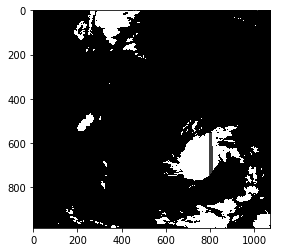

In [77]:
temp=y
M=984
N=1074
def floodFillUtil(screen, x, y, prevC, newC): 

    # Base cases 
    if (x < 0 or x >= M or y < 0 or 
        y >= N or screen[x][y] != prevC or 
        screen[x][y] == newC): 
        return

    # Replace the color at (x, y) 
    screen[x][y] = newC 

    # Recur for north, east, south and west 
    floodFillUtil(screen, x + 1, y, prevC, newC) 
    floodFillUtil(screen, x - 1, y, prevC, newC) 
    floodFillUtil(screen, x, y + 1, prevC, newC) 
    floodFillUtil(screen, x, y - 1, prevC, newC) 

# It mainly finds the previous color on (x, y) and  
# calls floodFillUtil()  
def floodFill(screen, x, y, newC): 
    prevC = screen[x][y]
    floodFillUtil(screen, x, y, prevC, newC) 
floodFill(temp, 600, 800, 1.0)
plt.imshow(temp, cmap='gray')

False
<class 'list'>


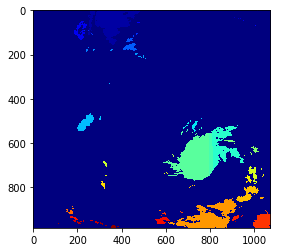

In [78]:

temp=y
cloud_labels = {}
def fill(data, start_coords, fill_value):
    global cloud_pixel_list, label_number
    xsize, ysize = data.shape
    orig_value = data[start_coords[0], start_coords[1]]
    stack = set(((start_coords[0], start_coords[1]),))
    if fill_value == orig_value:
        raise ValueError("Filling region with same value "
                     "already present is unsupported. "
                     "Did you already fill this region?")

    while stack:
        x, y = stack.pop()

        if data[x, y] == orig_value:
            data[x, y] = fill_value
            if [x, y] in cloud_pixel_list:
                cloud_pixel_list.remove([x, y])
            if [x, y] not in cloud_labels[label_number]:
                cloud_labels[label_number].append([x,y])
            if x > 0:
                stack.add((x - 1, y))
            if x < (xsize - 1):
                stack.add((x + 1, y))
            if y > 0:
                stack.add((x, y - 1))
            if y < (ysize - 1):
                stack.add((x, y + 1))

print([800, 600] in cloud_pixel_list)
global label_number
label_number=6
print(type(cloud_pixel_list))
while len(cloud_pixel_list) > 0:
    cloud_labels[label_number] = []
    fill(temp, cloud_pixel_list[0], label_number)
    label_number+=1
plt.imshow(temp, cmap='jet')
#plt.plot([800], [600], marker='o', markersize=3, color="red")



178


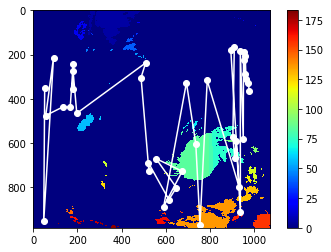

In [79]:
print(len(cloud_labels))
com_labels={}
cloud_labels_filtered=[]
x_points=[]
y_points=[]
for label in cloud_labels:
    if len(cloud_labels[label]) <= 50:
        continue
    flag=False
    for pixel in cloud_labels[label]:
        if pixel[0]>=1060.0 or pixel[1]>=980.0:
            flag=True
            break
    if flag:
        continue
    x=0
    m=0
    y=0
    cloud_labels_filtered.append(label)
    for pixel in cloud_labels[label]:
        x+=b[pixel[0], pixel[1]]*pixel[0]
        y+=b[pixel[0], pixel[1]]*pixel[1]
        m+=b[pixel[0], pixel[1]]
    x_points.append(x/m)
    y_points.append(y/m)
    com_labels[label] = [x/m, y/m]

plt.imshow(temp, cmap='jet')
plt.colorbar()
plt.plot(x_points, y_points, marker='o', color="white")

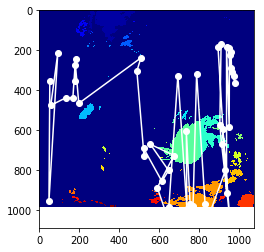

In [80]:
cgx_p=[]
cgy_p=[]
for label in cloud_labels:
    if len(cloud_labels[label]) <= 50:
        continue
    flag=False
    for pixel in cloud_labels[label]:
        if pixel[0]==984 or pixel[1]==1074:
            flag=True
    if flag:
        continue
    xp=[]
    yp=[]
    mp=[]
    for pixel in cloud_labels[label]:
        xp.append(pixel[0])
        yp.append(pixel[1])
        mp.append(b[pixel[0], pixel[1]])
    xp=np.array(xp)
    yp=np.array(yp)
    m=np.average(mp)
    cgx_p.append(np.sum(xp*m)/np.sum(mp))
    cgy_p.append(np.sum(yp*m)/np.sum(mp))
plt.imshow(temp, cmap='jet')
plt.plot(cgx_p, cgy_p, marker='o', color="white")

In [81]:
avg_x = {}
avg_y = {}
mass={}
avg_gray={}
major_minor={}
list_features=[]
for label in cloud_labels:
    if len(cloud_labels[label]) <= 50:
        continue
    flag=False
    for pixel in cloud_labels[label]:
        if pixel[0]>=1060.0 or pixel[1]>=980.0:
            flag=True
            break
    if flag:
        continue
    sum_x=0
    sum_y=0
    sum_b=0
    max_x=-99
    max_y=-99
    min_x=1000
    min_y=1000
    for pixel in cloud_labels[label]:
        sum_x+=pixel[0]
        sum_y+=pixel[1]
        sum_b+=b[pixel[0], pixel[1]]
        max_x=max(pixel[0], max_x)
        min_x=min(pixel[0], min_x)
        max_y=max(pixel[1], max_y)
        min_y=min(pixel[1], min_y)
    avg_x[label]=sum_x/len(cloud_labels[label])
    avg_y[label]=sum_y/len(cloud_labels[label])
    mass[label]=len(cloud_labels[label])
    avg_gray[label]=sum_b/len(cloud_labels[label])
    major_minor[label]=(max_y-min_y)/(max_x-min_x)
    list_features.append({'label': label, 'avg_x': avg_x[label], 'avg_y': avg_y[label], 'mass': mass[label], 'major_minor':major_minor[label], 'com_x':com_labels[label][0], 'com_y':com_labels[label][1]})

In [82]:
df=pd.DataFrame(list_features)
df=df.set_index('label')
print(df)

            avg_x       avg_y       com_x       com_y  major_minor   mass
label                                                                    
6       52.052745  352.789078   52.045527  352.796199     1.496815  17708
17      47.781818  953.454545   47.779183  953.440858     4.400000     55
18      92.029295  213.417080   91.969750  213.420852     0.670455   2014
20      56.862745  475.372549   56.865931  475.360832     2.200000     51
38     134.921053  436.247368  134.918138  436.224608     1.894737    380
40     167.529714  438.195891  167.504787  438.177150     1.750000   1363
45     180.798246  242.736842  180.802311  242.736345     0.705882    114
47     178.243902  353.768293  178.248267  353.766170     1.000000     82
48     180.475410  273.426230  180.481942  273.420568     1.222222     61
50     197.238806  465.417910  197.241095  465.414194     1.750000     67
57     508.489092  237.539564  508.835959  237.171675     0.937500   3071
59     488.175000  303.366667  488.135

In [83]:
df.to_csv(image_file+'.csv')